In [ ]:
import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
#!pip install catboost
#from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
def fill_missing_values(data):
    
    '''
    Function to input missing values based on the column object type
    '''
    
    cols = list(data.columns)
    for col in cols:
        if data[col].dtype == 'int64' or data[col].dtype == 'float64':
        
            data[col] = data[col].fillna(data[col].mean())
        
        #elif data[col].dtype == 'O' or data[col].dtype == 'object':
        #    data[col] = data[col].fillna(data[col].mode()[0])
            
        else:
            data[col] = data[col].fillna(data[col].mode()[0])
            
    return data
 
def one_hot_encoding(traindata, *args):
    
    for ii in args:
        traindata = pd.get_dummies(traindata, prefix=[ii], columns=[ii])
        
    return traindata
 
def drop_columns(traindata, *args):
    
    #labels = np.array(traindata[target])
    
    columns = []
    for _ in args:
        columns.append(_)
        
    traindata = traindata.drop(columns, axis=1)
    #traindata = traindata.drop(target, axis=1)
    #testdata = testdata.drop(columns, axis=1)
        
    return traindata
 
def process(traindata):
    
    cols = list(traindata.columns)
    for _ in cols:
        traindata[_] = np.where(traindata[_] == np.inf, -999, traindata[_])
        traindata[_] = np.where(traindata[_] == np.nan, -999, traindata[_])
        traindata[_] = np.where(traindata[_] == -np.inf, -999, traindata[_])
        
    return traindata
 
def show_evaluation(pred, true):
  print(f'Default score: {score(true.values, pred)}')
  print(f'Accuracy is: {accuracy_score(true, pred)}')
  print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')
 
def freq_encode(data, cols):
    for i in cols:
        encoding = data.groupby(i).size()
        encoding = encoding/len(data)
        data[i + '_enc'] = data[i].map(encoding)
    return data
 
 
def mean_target(data, cols):
    kf = StratifiedKFold(10, shuffle=False)
    a = pd.DataFrame()
    for tr_ind, val_ind in kf.split(data, data.FORCE_2020_LITHOFACIES_LITHOLOGY):
        X_tr, X_val= data.iloc[tr_ind].copy(), data.iloc[val_ind].copy()
        for col in cols:
            means = X_val[col].map(X_tr.groupby(col).FORCE_2020_LITHOFACIES_LITHOLOGY.mean())
            X_val[col + '_mean_target'] = means + 0.0001
        a = pd.concat((a, X_val))
    #prior = FORCE_2020_LITHOFACIES_LITHOLOGY.mean()
    #a.fillna(prior, inplace=True)
    return a
 
def make_submission(prediction, filename):
 
  path = '/content/drive/My Drive/FORCE-Lithology-Prediction/'
 
  test = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/Test.csv', sep=';')
  #test_prediction = model.predict(testdata)
 
  #test_prediction
  category_to_lithology = {y:x for x,y in lithology_numbers.items()}
  test_prediction_for_submission = np.vectorize(category_to_lithology.get)(prediction)
  np.savetxt(path+filename+'.csv', test_prediction_for_submission, header='lithology', fmt='%i')
 
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug
 
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad
 
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

In [ ]:
A = np.load('/content/drive/My Drive/FORCE-Lithology-Prediction/penalty_matrix.npy')
 
def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]
 
def evaluate(model):
    feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
    plt.figure(figsize=(24,8))
    feat_imp.plot(kind='bar', title=f'Feature Importances {len(model.feature_importances_)}')
    plt.ylabel('Feature Importance Score')

In [ ]:
#importing files
train = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/train1.csv')
test = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/Test.csv', sep=';')
valid1 = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/valid4.csv')
valid2 = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/valid5.csv')
valid3 = pd.concat((valid1, valid2)).reset_index(drop=True)

In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]
nvalid1 = valid1.shape[0]
nvalid2 = valid2.shape[0]
nvalid3 = valid3.shape[0]
target = train.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
df = pd.concat((train, test, valid1, valid2, valid3)).reset_index(drop=True)

In [ ]:
train_well = train.WELL.values
train_depth = train.DEPTH_MD.values
 
valid1_well = valid1.WELL.values
valid1_depth = valid1.DEPTH_MD.values
 
valid2_well = valid2.WELL.values
valid2_depth = valid2.DEPTH_MD.values
 
valid3_well = valid3.WELL.values
valid3_depth = valid3.DEPTH_MD.values

In [ ]:
lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid1_lithology = valid1['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid2_lithology = valid2['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid3_lithology = valid3['FORCE_2020_LITHOFACIES_LITHOLOGY']
 
lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}
 
lithology = lithology.map(lithology_numbers)
valid1_lithology = valid1_lithology.map(lithology_numbers)
valid2_lithology = valid2_lithology.map(lithology_numbers)
valid3_lithology = valid3_lithology.map(lithology_numbers)

In [ ]:
 print(df.shape)
cols = ['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA']
df = drop_columns(df, *cols)
print(df.shape)

(1512843, 29)
(1512843, 24)


In [ ]:
df['GROUP_encoded'] = df['GROUP'].astype('category')
df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes
df['FORMATION_encoded'] = df['FORMATION'].astype('category')
df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes
df['WELL_encoded'] = df['WELL'].astype('category')
df['WELL_encoded'] = df['WELL_encoded'].cat.codes

In [ ]:
df = df.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)
df.shape
 
df = df.fillna(-999)
df = process(df)
data = df.copy()
 
train2 = data[:ntrain].copy()
target = train2.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
validation1_target = valid1.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
validation2_target = valid2.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
train2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
 
test2 = data[ntrain:(ntest+ntrain)].copy()
test2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
test2 = test2.reset_index(drop=True)
 
validation1 = data[(ntest+ntrain):(ntest+ntrain+nvalid1)].copy()
validation1.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
validation1 = validation1.reset_index(drop=True)
 
validation2 = data[(ntrain+ntest+nvalid1): (ntrain+ntest+nvalid1+nvalid2)].copy()
validation2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
validation2 = validation2.reset_index(drop=True)
 
 
validation3 = data[(ntrain+ntest+nvalid1+nvalid2):].copy()
validation3.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
validation3 = validation3.reset_index(drop=True)
 
print(train2.shape, test2.shape, validation1.shape, valid1.shape, validation2.shape, validation3.shape, valid2.shape)

(964965, 23) (136786, 23) (114079, 23) (114079, 29) (91467, 23) (205546, 23) (91467, 29)


In [ ]:
traindata = train2
testdata = test2
from sklearn.preprocessing import StandardScaler
 
scaler = StandardScaler().fit(traindata)
def scale_data(data):
  
  data = scaler.transform(data)
  #testdata = scaler.transform(testdata)
  data = pd.DataFrame(data, columns=testdata.columns)
 
  return data

In [ ]:
traindata, padded_rows = augment_features(traindata.values, train_well, train_depth)
validation1, padded_rows1= augment_features(validation1.values, valid1_well, valid1_depth)
validation2, padded_rows2 = augment_features(validation2.values, valid2_well, valid2_depth)
validation3, padded_rows3 = augment_features(validation3.values, valid3_well, valid3_depth)

In [ ]:
traindata.shape, validation1.shape, validation3.shape, validation2.shape

((964965, 92), (114079, 92), (205546, 92), (91467, 92))

In [ ]:
class Model():
    
    def __init__(self, train, validation1, validation2, validation3, train_label, valid_label1, valid_label2, valid_label3):
        
        
        self.train = train
        #self.test = test
        self.validation1 = validation1
        self.validation2 = validation2
        self.validation3 = validation3
        self.train_label = train_label
        self.valid_label1 = valid_label1
        self.valid_label2 = valid_label2
        self.valid_label3 = valid_label3
        
    def __call__(self, plot = True):
        return self.fit(plot)
    
    def fit(self, plot):
 
      #self.x_train, self.x_test, self.y_train, self.y_test = ms.train_test_split(self.train, 
                                                                                  # pd.DataFrame(np.array(self.train_label)), 
                                                                                   #test_size=0.2,
                                                                                   #random_state=212)
      #self.x_train = self.train.iloc[:700000]
      #self.x_test = self.train.iloc[700000:]
      #self.y_train = pd.DataFrame(self.train_label).iloc[:700000]
      #self.y_test = pd.DataFrame(self.train_label).iloc[700000:]
      
      def show_evaluation(pred, true):
        
        print(f'Default score: {score(true.values, pred)}')
        print(f'Accuracy is: {accuracy_score(true, pred)}')
        print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')
 
      split = 10
      kf = StratifiedKFold(n_splits=split, shuffle=False)
  
      #pred = np.zeros((len(self.test), 12))
      val1 = np.zeros((len(self.validation1), 12))
      val2 = np.zeros((len(self.validation2), 12))
      val3 = np.zeros((len(self.validation3), 12))
 
      #model = CatBoostClassifier(n_estimators=500000, random_state=2020, learning_rate=0.01,
                                 #use_best_model=True, max_depth=6, reg_lambda=500,
                                 #eval_metric='MultiClass', task_type='GPU', verbose=100)
 
      model = XGBClassifier(n_estimators=50000, max_depth=11, reg_lambda=1500, reg_alpha=500, gamma=500,
                            objective='multi:softprob', learning_rate=0.033, colsample_bylevel=0.9,
                            subsample=0.9, col_sample_bytree=0.9, tree_method='gpu_hist',
                            eval_metric='mlogloss', verbose=2020, colsample_bynode=0.9)
      
      #model = LGBMClassifier(n_estimators=50000, max_depth=10, reg_lambda=200,
                            #objective='multiclass', learning_rate=0.033,
                            #eval_metric='multi_logloss')
      
      #model = RandomForestClassifier(n_estimators=100, class_weight='balanced', verbose=2)
      i = 1
      for (train_index, test_index) in kf.split(pd.DataFrame(traindata), pd.DataFrame(lithology)):
        X_train,X_test = pd.DataFrame(traindata).iloc[train_index], pd.DataFrame(traindata).iloc[test_index]
        Y_train,Y_test = pd.DataFrame(lithology).iloc[train_index],pd.DataFrame(lithology).iloc[test_index]
    
        
        model.fit(X_train, Y_train, early_stopping_rounds=100, eval_set=[(X_test, Y_test)], verbose=100)
        #model.fit(X_train, Y_train)
        prediction1 = model.predict(self.validation1)
        prediction = model.predict(self.validation2)
        print(show_evaluation(prediction1, self.valid_label1))
        print(show_evaluation(prediction, self.valid_label2))
 
        print(f'-----------------------FOLD {i}---------------------')
        i+=1
 
        #pred += model.predict_proba(self.test)
        val1 += model.predict_proba(self.validation1)
        val2 += model.predict_proba(self.validation2)
        val3 += model.predict_proba(self.validation3)
      
      #pred = pd.DataFrame(pred/split)
      val1 = pd.DataFrame(val1/split)
      val2 = pd.DataFrame(val2/split)
      val3 = pd.DataFrame(val3/split)
    
      #pred = np.array(pd.DataFrame(pred).idxmax(axis=1))
      val1 = np.array(pd.DataFrame(val1).idxmax(axis=1))
      val2 = np.array(pd.DataFrame(val2).idxmax(axis=1))
      val3 = np.array(pd.DataFrame(val3).idxmax(axis=1))
 
      print('---------------CROSS VALIDATION COMPLETE')
      print('----------------TEST EVALUATION------------------')
 
      print('----------Valid 1-------------')
      print(show_evaluation(val1, self.valid_label1))
      print('----------Valid 2-------------')
      print(show_evaluation(val2, self.valid_label2))
      print('----------Valid 3-------------')
      print(show_evaluation(val3, self.valid_label3))
                  
      if plot: self.plot_feat_imp(model)
      return val1, val2, val3, model
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [ ]:
class Model():
    
    def __init__(self, train, validation1, validation2, validation3, train_label, valid_label1, valid_label2, valid_label3):
        
        
        self.train = train
        #self.test = test
        self.validation1 = validation1
        self.validation2 = validation2
        self.validation3 = validation3
        self.train_label = train_label
        self.valid_label1 = valid_label1
        self.valid_label2 = valid_label2
        self.valid_label3 = valid_label3
        
    def __call__(self, plot = True):
        return self.fit(plot)
    
    def fit(self, plot):
 
      #self.x_train, self.x_test, self.y_train, self.y_test = ms.train_test_split(self.train, 
                                                                                  # pd.DataFrame(np.array(self.train_label)), 
                                                                                   #test_size=0.2,
                                                                                   #random_state=212)
      #self.x_train = self.train.iloc[:700000]
      #self.x_test = self.train.iloc[700000:]
      #self.y_train = pd.DataFrame(self.train_label).iloc[:700000]
      #self.y_test = pd.DataFrame(self.train_label).iloc[700000:]
      
      def show_evaluation(pred, true):
        
        print(f'Default score: {score(true.values, pred)}')
        print(f'Accuracy is: {accuracy_score(true, pred)}')
        print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')
 
      split = 10
      kf = StratifiedKFold(n_splits=split, shuffle=True)
  
      #pred = np.zeros((len(self.test), 12))
      val1 = np.zeros((len(self.validation1), 12))
      val2 = np.zeros((len(self.validation2), 12))
      val3 = np.zeros((len(self.validation3), 12))
 
      model = CatBoostClassifier(n_estimators=500, learning_rate=0.033,
                                 use_best_model=True, max_depth=8, reg_lambda=1500,
                                 eval_metric='MultiClass', task_type='GPU', verbose=100)
 
      #model = XGBClassifier(n_estimators=1000, max_depth=11, reg_lambda=1500, booster_type='gbtree',
                            #objective='multi:softprob', learning_rate=0.033,
                            #subsample=0.9, col_sample_bytree=0.9, tree_method='gpu_hist', 
                            #eval_metric='mlogloss', verbose=2020)
      
      #model = LGBMClassifier(n_estimators=50000, max_depth=10, reg_lambda=200,
                            #objective='multiclass', learning_rate=0.033,
                            #eval_metric='multi_logloss')
      
      #model = RandomForestClassifier(n_estimators=100, class_weight='balanced', verbose=2)
      i = 1
      for (train_index, test_index) in kf.split(pd.DataFrame(traindata), pd.DataFrame(lithology)):
        X_train,X_test = pd.DataFrame(traindata).iloc[train_index], pd.DataFrame(traindata).iloc[test_index]
        Y_train,Y_test = pd.DataFrame(lithology).iloc[train_index],pd.DataFrame(lithology).iloc[test_index]
    
        
        model.fit(X_train, Y_train, early_stopping_rounds=100, eval_set=[(X_test, Y_test)], verbose=100)
        #model.fit(X_train, Y_train)
        prediction1 = model.predict(pd.DataFrame(self.validation1))
        prediction = model.predict(pd.DataFrame(self.validation2))
        print(show_evaluation(prediction1, self.valid_label1))
        print(show_evaluation(prediction, self.valid_label2))
 
        print(f'-----------------------FOLD {i}---------------------')
        i+=1
 
        #pred += model.predict_proba(self.test)
        val1 += model.predict_proba(pd.DataFrame(self.validation1))
        val2 += model.predict_proba(pd.DataFrame(self.validation2))
        val3 += model.predict_proba(pd.DataFrame(self.validation3))
      
      #pred = pd.DataFrame(pred/split)
      val1 = pd.DataFrame(val1/split)
      val2 = pd.DataFrame(val2/split)
      val3 = pd.DataFrame(val3/split)
    
      #pred = np.array(pd.DataFrame(pred).idxmax(axis=1))
      val1 = np.array(pd.DataFrame(val1).idxmax(axis=1))
      val2 = np.array(pd.DataFrame(val2).idxmax(axis=1))
      val3 = np.array(pd.DataFrame(val3).idxmax(axis=1))
 
      print('---------------CROSS VALIDATION COMPLETE')
      print('----------------TEST EVALUATION------------------')
 
      print('----------Valid 1-------------')
      print(show_evaluation(val1, self.valid_label1))
      print('----------Valid 2-------------')
      print(show_evaluation(val2, self.valid_label2))
      print('----------Valid 3-------------')
      print(show_evaluation(val3, self.valid_label3))
                  
      if plot: self.plot_feat_imp(model)
      return val1, val2, val3, model
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [ ]:
func1_= Model(traindata, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
val1, open_test1, open_test11, model1 = func1_()   #no reglambda, 0.01 lr, 6max-depth (dts, rxo, sgr, ropa)

0:	learn: 2.3728927	test: 2.3726813	best: 2.3726813 (0)	total: 67.7ms	remaining: 33.8s
100:	learn: 0.7696968	test: 0.7663310	best: 0.7663310 (100)	total: 6.35s	remaining: 25.1s
200:	learn: 0.6022158	test: 0.5995316	best: 0.5995316 (200)	total: 12.3s	remaining: 18.2s
300:	learn: 0.5430381	test: 0.5408642	best: 0.5408642 (300)	total: 18.2s	remaining: 12s
400:	learn: 0.5114508	test: 0.5097472	best: 0.5097472 (400)	total: 23.9s	remaining: 5.89s
499:	learn: 0.4882004	test: 0.4867317	best: 0.4867317 (499)	total: 29.4s	remaining: 0us
bestTest = 0.4867316552
bestIteration = 499
Default score: [-0.75468097]
Accuracy is: 0.713926314220847
F1 is: 0.7320726655512828
None
Default score: [-0.59506161]
Accuracy is: 0.7797784993494922
F1 is: 0.8139235277621336
None
-----------------------FOLD 1---------------------
0:	learn: 2.3732203	test: 2.3731946	best: 2.3731946 (0)	total: 69.6ms	remaining: 34.7s
100:	learn: 0.7701419	test: 0.7645077	best: 0.7645077 (100)	total: 6.43s	remaining: 25.4s
200:	learn: 

KeyboardInterrupt: ignored

0:	learn: 2.4025523	test: 2.4552740	best: 2.4552740 (0)	total: 302ms	remaining: 4h 11m 30s
100:	learn: 0.8624995	test: 1.5903336	best: 1.5903336 (100)	total: 22.3s	remaining: 3h 3m 39s
200:	learn: 0.6177713	test: 1.4078229	best: 1.4078229 (200)	total: 43.8s	remaining: 3h 59s
300:	learn: 0.5195834	test: 1.3705727	best: 1.3652614 (254)	total: 1m 3s	remaining: 2h 55m 38s
bestTest = 1.365261355
bestIteration = 254
Shrink model to first 255 iterations.
Default score: [-0.76779907]
Accuracy is: 0.714189289878067
F1 is: 0.7446878302880734
None
Default score: [-0.60574852]
Accuracy is: 0.7729345009675621
F1 is: 0.8143156381894381
None
-----------------------FOLD 1---------------------
0:	learn: 2.4155061	test: 2.4159041	best: 2.4159041 (0)	total: 315ms	remaining: 4h 22m 10s
100:	learn: 0.8545950	test: 1.3988379	best: 1.3985574 (99)	total: 22.6s	remaining: 3h 5m 54s
200:	learn: 0.6300971	test: 1.3567600	best: 1.3533327 (197)	total: 45.2s	remaining: 3h 6m 50s
300:	learn: 0.5215040	test: 1.317256

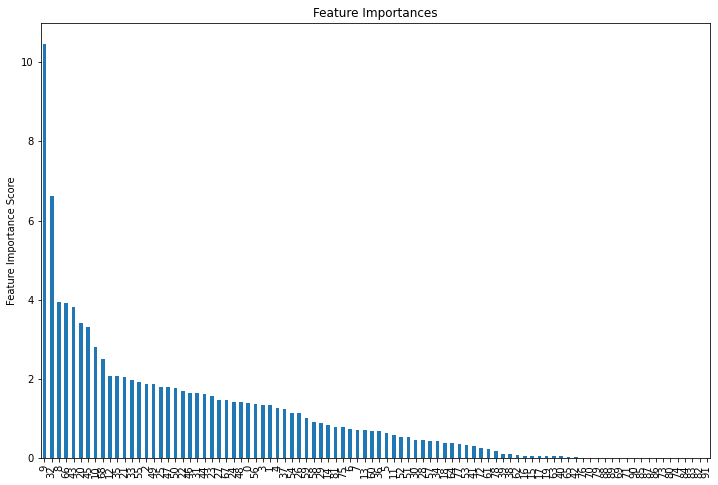

In [ ]:
func1_= Model(traindata, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
val1, open_test1, open_test11, model1 = func1_()   #no reglambda, 0.01 lr, 6max-depth (dts, rxo, sgr, ropa)

In [ ]:
make_submission(open_test1, 'open_test1_pred1')
 
a = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/open_test1_pred1.csv')
 
a['# lithology'].value_counts()

65000    72937
30000    10735
70000     3704
65030     1796
99000     1403
80000      889
90000        3
Name: # lithology, dtype: int64

In [ ]:
valid2.FORCE_2020_LITHOFACIES_LITHOLOGY.value_counts()

65000    62703
30000    11898
65030     7990
70000     4217
80000     2635
99000     1337
90000      531
70032      112
74000       44
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

In [ ]:
print(show_evaluation(val1,valid1_lithology))
print(show_evaluation(open_test1, valid2_lithology))
print(show_evaluation(open_test11, valid3_lithology))

Default score: -0.6287890409277781
Accuracy is: 0.7649523575767669
F1 is: 0.8072991891979571
None
Default score: -0.5854133184645829
Accuracy is: 0.785398012397914
F1 is: 0.8225863227488472
None
Default score: -0.6094870491276891
Accuracy is: 0.7740505774863048
F1 is: 0.8132635081176378
None
